# Recommender Systems

In this exercise we evaluated various recommender systems and tried to improve it using different techniques. The Amazon fine food data were used for this practices. This data were acquired from kaggle. 

# Step 1: Importing dependencies, loading data and EDA

In [1]:
# importing dependencies

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

In [17]:
# loading data

path = "data_file"
df = pd.read_csv(os.path.join(path, "reviews.csv"))
df_copy = df.copy()

In [3]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [4]:
# Exploratory Data Analysis

# number of unique users and items
n_users = df.UserId.unique().shape[0]
n_items = df.ProductId.unique().shape[0]
print(f"This dataset has {n_users} numbers of unique users, and includes ratings of {n_items} items")

This dataset has 256059 numbers of unique users, and includes ratings of 74258 items


In [5]:
# User's rating counts
user_freq = df[['UserId', 'ProductId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_ratings']
user_freq.sort_values('n_ratings', ascending=False).head(10)

,UserId,n_ratings
182011,A3OXHLG6DIBRW8,448
65586,A1YUL9PCJR3JTY,421
252275,AY12DBB0U420B,389
82919,A281NPSIMI1C2R,365
66162,A1Z54EM24Y40LL,256
55736,A1TMAVN4CEM8U8,204
110863,A2MUGFV2TDQ47K,201
191283,A3TVZM3ZIXG8YW,199
183161,A3PJZ8TU8FDQ1K,178
238453,AQQLWCMRNDFGI,176


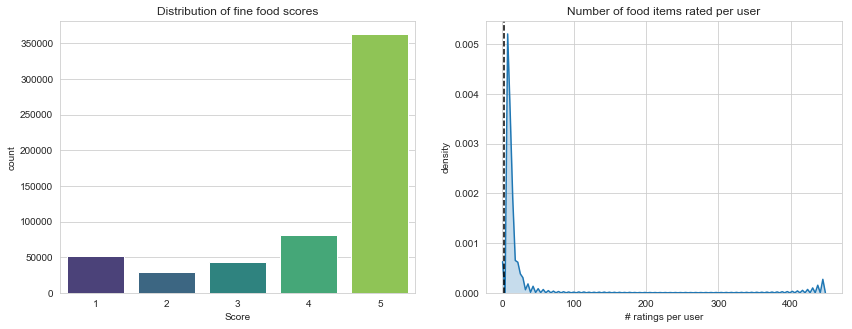

In [6]:
# Distribution of rating and number of ratings per user
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="Score", data=df, palette="viridis")
plt.title("Distribution of fine food scores")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of food items rated per user")
plt.show()

In [7]:
# number of users with only 1 ratings
n_users_one = user_freq[user_freq['n_ratings']==1].shape[0]
print(f"Out of {n_users} total unique users, {n_users_one} ({round((n_users_one/n_users)*100,2)}%) users only rated one item.")

# number of users with 2 ratings
n_users_two = user_freq[user_freq['n_ratings']==2].shape[0]
print(f"Out of {n_users} total unique users, {n_users_two} ({round((n_users_two/n_users)*100,2)}%) users rated two items.")

# number of users with 3 ratings
n_users_three = user_freq[user_freq['n_ratings']==3].shape[0]
print(f"Out of {n_users} total unique users, {n_users_three} ({round((n_users_three/n_users)*100,2)}%) users rated three items.")

user_freq.describe()

Out of 256059 total unique users, 175391 (68.5%) users only rated one item.
Out of 256059 total unique users, 32658 (12.75%) users rated two items.
Out of 256059 total unique users, 13828 (5.4%) users rated three items.


,n_ratings
count,256059.000000
mean,2.220012
std,4.443361
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,448.000000


As shown in the above graphs: 
(1) The reviews tend to be more positive (biased toward more positive reviews)
(2) Very few people provides more than 1 reviews (which leads to a very sparse matrix later developing our recommender)

In [8]:
# Item rating counts
item_freq = pd.DataFrame(df['ProductId'].value_counts().reset_index())
item_freq.columns = ['ProductId', 'n_ratings']
item_freq.sample(10)

,ProductId,n_ratings
11659,B001E5E38K,9
39638,B0092VQC3W,2
49761,B0008G2ENC,1
23958,B000I62U0O,4
40398,B0031TX7NY,2
30741,B000M5SHSK,3
50957,B0006MU8SG,1
48564,B003FPR1QS,1
66095,B001E0KVZ4,1
187,B003FDC2I2,257


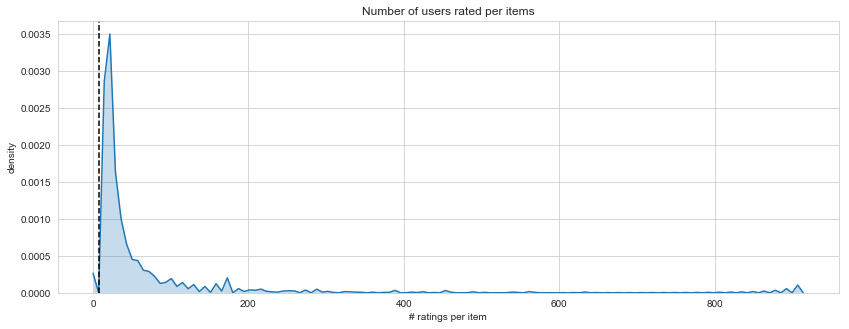

In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,1,1)
ax = sns.kdeplot(item_freq['n_ratings'], shade=True, legend=False)
plt.axvline(item_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per item")
plt.ylabel("density")
plt.title("Number of users rated per items")
plt.show()

In [10]:
# number of items with 1 ratings
n_items_one = item_freq[item_freq['n_ratings']==1].shape[0]
print(f"Out of {n_items} total unique items, {n_items_one} ({round((n_items_one/n_items)*100,2)}%) itmes only recieved one score.")

# number of items with 2 ratings
n_items_two = item_freq[item_freq['n_ratings']==2].shape[0]
print(f"Out of {n_items} total unique items, {n_items_two} ({round((n_items_two/n_items)*100,2)}%) itmes only recieved two scores.")

# number of items with 3 ratings
n_items_three = item_freq[item_freq['n_ratings']==3].shape[0]
print(f"Out of {n_items} total unique items, {n_items_three} ({round((n_items_three/n_items)*100,2)}%) itmes only recieved three score.")

item_freq.describe()

Out of 74258 total unique items, 30408 (40.95%) itmes only recieved one score.
Out of 74258 total unique items, 12262 (16.51%) itmes only recieved two scores.
Out of 74258 total unique items, 6849 (9.22%) itmes only recieved three score.


,n_ratings
count,74258.000000
mean,7.655121
std,26.453485
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,913.000000


Above statistics shows that about 60% of the items have one or more ratings

In [12]:
# Now checking whether we have more than one user-item interactions
df_grouped_interaction = pd.DataFrame(df.groupby(['UserId','ProductId']).size().reset_index())
df_grouped_interaction.columns = ['UserId','ProductId','count']
print(f"There are {df_grouped_interaction[df_grouped_interaction['count']>1].shape[0]} user_item interactions that occured more than one time.")

There are 5859 user_item interactions that occured more than one time.


In [18]:
# to deal with this group we use aggregate functions
# Datasets with aggregated measures
df['Summary'] = df['Summary'].astype(str).apply(lambda x: x.split())
df_agg = df.groupby(['UserId', 'ProductId']).agg({'HelpfulnessNumerator': 'mean',
                                                  'HelpfulnessDenominator':'mean', 
                                                  'Score':'mean', 
                                                  'Time': 'max', 
                                                  'Summary':'sum',
                                                  'Text':'-'.join}).reset_index()
df_agg.head()

,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,#oc-R103C0QSV1DF5E,B006Q820X0,1.0,2.0,5.0,1343088000,"[Great, for, the, Price]",I have to say I was a little apprehensive to b...
1,#oc-R109MU5OBBZ59U,B008I1XPKA,0.0,1.0,5.0,1350086400,"[AWESOME, Coffee!!!!]",Received my free K cups as a sample promotion ...
2,#oc-R10LFEMQEW6QGZ,B008I1XPKA,0.0,1.0,5.0,1345939200,"[Brooklyn, Bean, Roastery, Breakfast, Blend, K...",Brooklyn Bean Roastery Blend K-Cups are great ...
3,#oc-R10LT57ZGIB140,B0026LJ3EA,0.0,0.0,3.0,1310601600,"[Some, damage]",The shipment of the dog food was quick. Howev...
4,#oc-R10UA029WVWIUI,B006Q820X0,0.0,0.0,1.0,1342483200,"[Less, than, satisfactory., I, gave, the, Broo...","Brooklyn ""French Roast"" K-Cup Coffee is not on..."


In [59]:
# now need to identify cases with only one interactions (per both item and user)
# this can be particularly of interest since we may not be able to judge the accuracy of those cases
# number of items and individuals with only one count of ratings

one_rating_user = user_summary[user_summary['Scorecount'] == 1]
one_rating_user_full = pd.merge(one_rating_user, df_agg[['UserId', 'ProductId']], on = 'UserId')

one_rating_item = item_summary[item_summary['Scorecount'] == 1]
one_rating_item_full = pd.merge(one_rating_item, df_agg[['UserId', 'ProductId']], on = 'ProductId')


# to find 1-1 user-interaction we use inner merge
one_user_item = pd.merge(one_rating_user_full[['UserId','ProductId']], one_rating_item_full[['ProductId','UserId']], 
                         how='inner', on=['UserId', 'ProductId'])

# now check whether the size of one_user_item is less than or equal to min (size of user, size of item)
print(one_user_item.shape[0] < min(one_rating_user_full.shape[0], one_rating_item_full.shape[0]))

True


In [65]:
# now removing those cases
print(f"Out of {df_agg.shape[0]} user_interaction we found {one_user_item.shape[0]} interactions that have 1-1 user-item")

# We created a dataset without those 1-1 interaction (I called them cold-cold start)
one_user_item_uid = list(one_user_item['UserId'])
df_clean = df_agg[~df_agg['UserId'].isin(one_user_item_uid)]
df_clean.head()                          

Out of 560804 user_interaction we found 14675 interactions that have 1-1 user-item


,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,#oc-R103C0QSV1DF5E,B006Q820X0,1.0,2.0,5.0,1343088000,"[Great, for, the, Price]",I have to say I was a little apprehensive to b...
1,#oc-R109MU5OBBZ59U,B008I1XPKA,0.0,1.0,5.0,1350086400,"[AWESOME, Coffee!!!!]",Received my free K cups as a sample promotion ...
2,#oc-R10LFEMQEW6QGZ,B008I1XPKA,0.0,1.0,5.0,1345939200,"[Brooklyn, Bean, Roastery, Breakfast, Blend, K...",Brooklyn Bean Roastery Blend K-Cups are great ...
3,#oc-R10LT57ZGIB140,B0026LJ3EA,0.0,0.0,3.0,1310601600,"[Some, damage]",The shipment of the dog food was quick. Howev...
4,#oc-R10UA029WVWIUI,B006Q820X0,0.0,0.0,1.0,1342483200,"[Less, than, satisfactory., I, gave, the, Broo...","Brooklyn ""French Roast"" K-Cup Coffee is not on..."


In [66]:
# average ratings
mean_rating = df_clean.groupby('ProductId')[['Score']].mean()
lowest_rated = mean_rating['Score'].idxmin()
highest_rated = mean_rating['Score'].idxmax()
df_clean[df_clean['ProductId']==highest_rated]

,UserId,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
404281,A3QD68O22M2XHQ,2841233731,0.0,0.0,5.0,1345852800,"[Great, recipe, book, for, my, babycook]",This book is easy to read and the ingredients ...


however, the average scores depends to the number of times each item has rated by users. A better measure of item popularity in this case will be the Bayesian Average.

In [70]:
food_stats = df_clean.groupby('ProductId')[['Score']].agg(['count', 'mean'])
food_stats.columns = food_stats.columns.droplevel()

In [86]:
c = food_stats['count'].mean()
m = food_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (c*m + ratings.sum())/(c+ratings.count())
    return bayesian_avg

bayesian_mean_ratings = df_clean.groupby('ProductId')['Score'].agg(bayesian_avg).reset_index()
bayesian_mean_ratings.columns = ['ProductId', 'Bayesian_avg']
bayesian_mean_ratings.sort_values('Bayesian_avg').head(1)
bayesian_mean_ratings.sort_values('Bayesian_avg').tail(1)

,ProductId,Bayesian_avg
6740,B000ED9L9E,4.914167


In [80]:
most_pop_item = df_clean[df_clean.ProductId=='B000ED9L9E']
least_pop_item = df_clean[df_clean.ProductId=='B006N3I69A']

In [81]:

# perhaps use it later when we find to have time-dependent path
# 1) datasets with one user-item interaction
# df_one_rate_per_user = pd.merge(df[['UserId', 'ProductId']].drop_duplicates(keep=False), 
#                                 df, 
#                                 how='inner', 
#                                 on=['UserId', 'ProductId'])    
# print(f"There are {df_one_rate_per_user.shape[0]} user-item interactions which only occured once in the dataset.")

# Step 2: Developing Recommender System

In this step we evaluated various approaches to develop a recommender system. We further compared the result of these analysis using explicit score provided by users, using latent semantic analysis of the text/summary, and also combination of both.

In [ ]:
# Data preparation